## Ablation Study
Appendix B in the paper

In [1]:
import os
wd = os.path.normpath(os.getcwd() + '/..')
os.chdir(wd)
os.getcwd()

'/home/hyunsung/Workspace/soccercpd'

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from joblib import Parallel, delayed
from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams['font.family'] = 'Arial'

In [3]:
%load_ext autoreload
%autoreload 2

from src.myconstants import *
from src.rolerep import RoleRep
from src.form_manager import FormManager

In [4]:
# Choose the mode among the followings:
# * Discrete g-segmentation: 'gseg_avg', 'gseg_union'
# * Other nonparametric CPD: 'kernel_cosine', 'kernel_rbf', 'rank'
# * Not applying CPD: 'noncpd'
mode = 'kernel_cosine'

In [5]:
activity_records = pd.read_csv('data/activity_records.csv', header=0, encoding='utf-8-sig')
form_periods = pd.read_pickle(f'data/{mode}/form_periods.pkl')
role_periods = pd.read_csv(f'data/{mode}/role_periods.csv', header=0, encoding='utf-8-sig')
role_records = pd.read_csv(f'data/{mode}/role_records.csv', header=0, encoding='utf-8-sig')
role_records.head()

,activity_id,player_period,form_period,role_period,session,start_dt,end_dt,duration,player_id,squad_num,player_name,base_role,x,y
0,12864,1,1,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820,1235,23,P23,8,-983.0,-1609.0
1,12864,1,1,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820,1248,7,P07,3,910.0,1568.0
2,12864,1,1,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820,1252,9,P09,5,1554.0,-577.0
3,12864,1,1,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820,1759,8,P08,4,-171.0,-457.0
4,12864,1,1,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820,1773,98,P98,10,1389.0,436.0


In [6]:
form_periods.shape, role_periods.shape

((883, 8), (2269, 7))

### Formation Clustering

In [7]:
def compute_delaunay_dists(i, n):
    form1 = form_periods.iloc[i]
    dist_row = []
    for j in range(n):
        form2 = form_periods.iloc[j]
        cost_mat = distance_matrix(form1['coords'], form2['coords'])
        _, perm = linear_sum_assignment(cost_mat)
        edge_mat1 = form1['edge_mat']
        edge_mat2 = form2['edge_mat'][perm][:, perm]
        dist_row.append(np.abs(edge_mat1 - edge_mat2).sum())
    return i, dist_row

In [8]:
n = len(form_periods)
dist_rows = Parallel(n_jobs=50)(delayed(compute_delaunay_dists)(i, n) for i in range(n))

dist_mat = np.zeros((n, n))
for i, dist_row in dist_rows:
    dist_mat[i] = dist_row

pd.DataFrame(dist_mat).to_csv(f'data/{mode}/form_dist_mat.csv', header=False, index=False)
dist_mat

array([[ 0.   ,  7.116,  6.396, ...,  4.804,  9.336,  9.606],
       [ 7.116,  0.   ,  6.984, ...,  8.844,  6.46 , 11.742],
       [ 6.396,  6.984,  0.   , ...,  6.86 ,  6.348,  6.986],
       ...,
       [ 4.804,  8.844,  6.86 , ...,  0.   , 16.692,  9.118],
       [ 9.336,  6.46 ,  6.348, ..., 16.692,  0.   ,  7.514],
       [ 9.606, 11.742,  6.986, ...,  9.118,  7.514,  0.   ]])

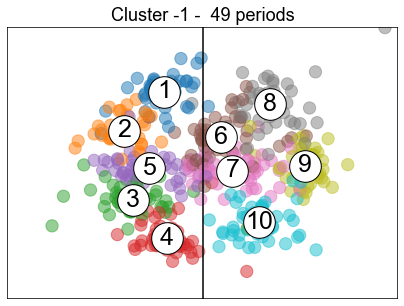

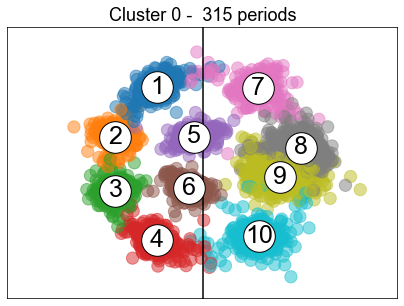

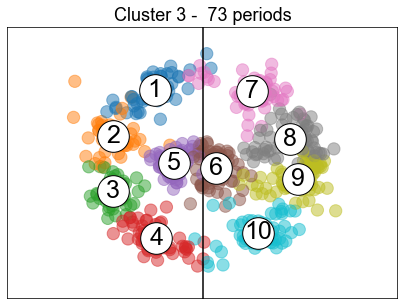

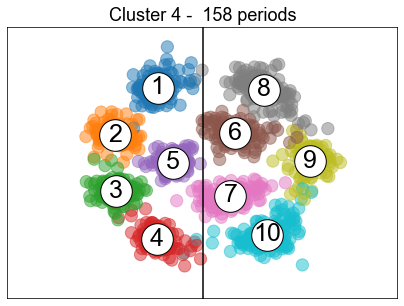

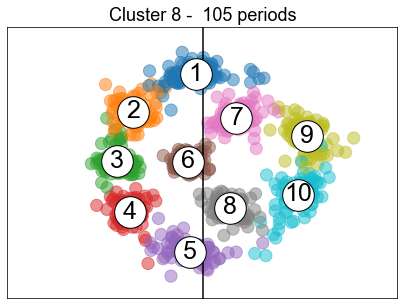

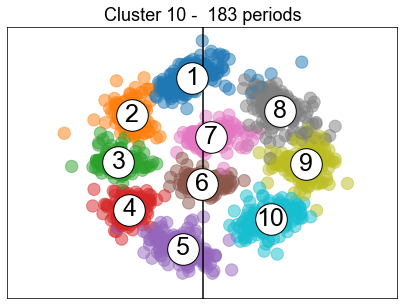

In [11]:
dist_mat = pd.read_csv(f'data/{mode}/form_dist_mat.csv', header=None).values

if mode in ['gseg_avg', 'noncpd']:
    n_clusters = 18
elif mode in ['gseg_union']:
    n_clusters = 22
elif mode in ['kernel_rbf', 'kernel_cosine', 'rank']:
    n_clusters = 24
else:
    n_clusters = 20

model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
model = model.fit(dist_mat)
counter = Counter(model.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 15:
        outliers.append(cluster)
form_periods['cluster'] = np.where(np.isin(model.labels_, outliers), -1, model.labels_)

fm = FormManager(form_periods)
fm.visualize(group_type=LABEL_CLUSTER, ignore_outliers=False)

In [12]:
if mode == 'gseg_avg':
    cluster = 1
    n_clusters = 18
elif mode == 'gseg_union':
    cluster = 0
    n_clusters = 15
elif mode == 'kernel_rbf':
    cluster = 5
    n_clusters = 15
elif mode == 'kernel_cosine':
    cluster = 0
    n_clusters = 15
elif mode == 'rank':
    cluster = 6
    n_clusters = 18
elif mode == 'noncpd':
    cluster = 2
    n_clusters = 15
else:
    cluster = 0
    n_clusters = 18

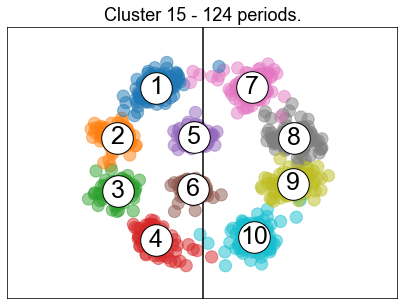

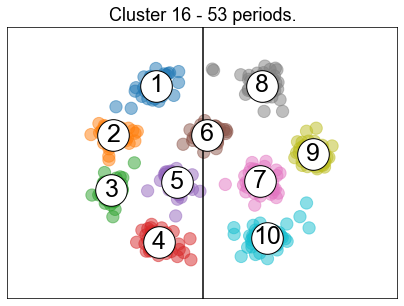

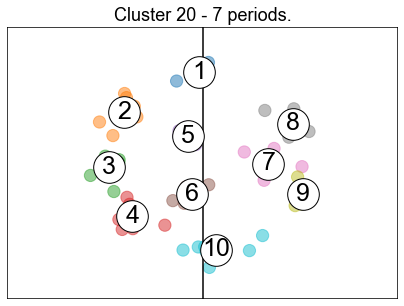

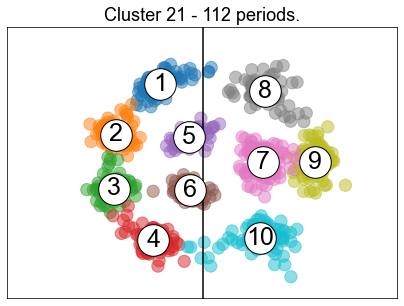

In [13]:
cluster_idxs = form_periods[form_periods['cluster'] == cluster].index
dist_mat_cluster = dist_mat[cluster_idxs][:, cluster_idxs]

submodel = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
submodel = submodel.fit(dist_mat_cluster)
counter = Counter(submodel.labels_)
outliers = []
for cluster, count in counter.items():
    if count < 5:
        outliers.append(cluster)
form_periods.loc[cluster_idxs, LABEL_CLUSTER] = np.where(
    np.isin(submodel.labels_, outliers), -1, submodel.labels_ + n_clusters
)
counts = form_periods.loc[cluster_idxs, LABEL_CLUSTER].value_counts()

clusters = [c for c in np.sort(form_periods.loc[cluster_idxs, LABEL_CLUSTER].unique()) if c != -1]
for c in clusters:
    fm.visualize_group(c, group_type=LABEL_CLUSTER)
    # plt.savefig(f'img/cluster_c{c}.pdf', bbox_inches='tight')
    plt.title(f'Cluster {c} - {counts[c]} periods.')

In [14]:
if mode == 'gseg_avg':
    clus_to_form = {
        0: '343', 12: '352', 20: '442', 16: '433', 30: '433', 5: '4132', 
        18: '4231', 19: '4231', 23: '4231', 26: '4231', -1: 'others'
    }
elif mode == 'gseg_union':
    clus_to_form = {
        4: '343', 10: '352', 16: '442', 6: '433', 1: '4132', 
        15: '4231', 20: '4231', 23: '4231',
        17: 'others', 18: 'others', 19: 'others', -1: 'others'
    }
elif mode == 'kernel_rbf':
    clus_to_form = {
        11: '343', 1: '352', 16: '442', 17: '442', 21: '442', 4: '433', 2: '4132',
        15: '4231', 19: '4231', 20: '4231', -1: 'others'
    }
elif mode == 'kernel_cosine':
    clus_to_form = {
        10: '343', 8: '352', 15: '442', 4: '433', 3: '4132',
        16: '4231', 21: '4231', 20: 'others', -1: 'others'
    }
elif mode == 'rank':
    clus_to_form = {
        0: '343', 10: '352', 18: '442', 3: '433', 8: '4132',
        19: '4231', 21: '4231', 20: 'others', 23: 'others', -1: 'others'
    }
elif mode == 'noncpd':
    clus_to_form = {
        0: '343', 14: '352', 15: '442', 25: '442', 4: '433', 6: '4132', 
        17: '4231', 18: '4231', 19: '4231', 20: '4231', 26: '4231', -1: 'others'
    }
else:
    clus_to_form = {}

In [15]:
form_periods[LABEL_FORMATION] = form_periods[LABEL_CLUSTER].apply(lambda x: clus_to_form[x])
form_periods.to_pickle(f'data/{mode}/form_periods.pkl')
form_periods

,activity_id,form_period,session,start_dt,end_dt,duration,coords,edge_mat,cluster,formation
0,12864,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-706.0, 1597.0], [-1362.0, 686.0], [910.0, 1...","[[0.0, 0.981, 0.953, 0.205, 0.027, 0.814, 0.27...",15,442
1,12868,1,1,2020-01-01 14:00:00,2020-01-01 14:47:00,2820.0,"[[-807.0, -1612.0], [44.0, 199.0], [-373.0, -2...","[[0.0, 0.31, 0.721, 0.997, 0.207, 0.049, 0.115...",3,4132
2,12868,2,2,2020-01-01 15:02:00,2020-01-01 15:50:00,2880.0,"[[-928.0, -1910.0], [-111.0, 658.0], [-206.0, ...","[[0.0, 0.168, 0.853, 0.989, 0.126, 0.042, 0.24...",21,4231
3,12870,1,1,2020-01-01 13:30:00,2020-01-01 14:19:00,2940.0,"[[-1400.0, 57.0], [439.0, -1071.0], [-283.0, 3...","[[0.0, 0.219, 0.884, 0.097, 0.395, 0.959, 0.34...",4,433
4,12870,2,2,2020-01-01 14:33:00,2020-01-01 15:23:00,3000.0,"[[-1266.0, -146.0], [292.0, -877.0], [-205.0, ...","[[0.0, 0.393, 0.871, 0.067, 0.217, 0.998, 0.28...",-1,others
...,...,...,...,...,...,...,...,...,...,...
878,9064,3,2,2020-01-01 16:27:10,2020-01-01 16:51:00,1430.0,"[[-1538.0, 511.0], [-1621.0, -701.0], [-0.0, -...","[[0.0, 0.984, 0.493, 0.047, 0.01, 0.025, 0.836...",3,4132
879,9281,1,1,2020-01-01 15:00:00,2020-01-01 15:47:00,2820.0,"[[-1437.0, 113.0], [-1109.0, -959.0], [1523.0,...","[[0.0, 0.969, 0.053, 0.032, 0.028, 0.201, 0.98...",10,343
880,9281,2,2,2020-01-01 16:03:00,2020-01-01 16:51:00,2880.0,"[[-1253.0, -90.0], [-1090.0, -1033.0], [1471.0...","[[0.0, 0.933, 0.042, 0.034, 0.061, 0.195, 0.97...",10,343
881,9285,1,1,2020-01-01 14:01:00,2020-01-01 14:48:00,2820.0,"[[-638.0, 1741.0], [-1425.0, 599.0], [-1561.0,...","[[0.0, 0.986, 0.243, 0.315, 0.159, 0.738, 0.23...",16,4231


### Role Labeling

Roles aligned for formation '343'
Roles aligned for formation '352'
Roles aligned for formation '4132'
Roles aligned for formation '4231'
Roles aligned for formation '433'
Roles aligned for formation '442'
Roles aligned for formation 'others'


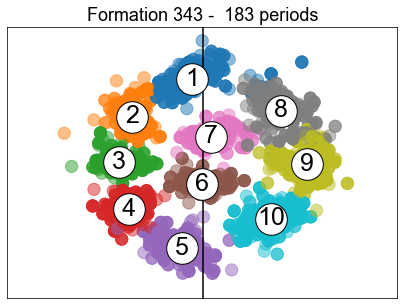

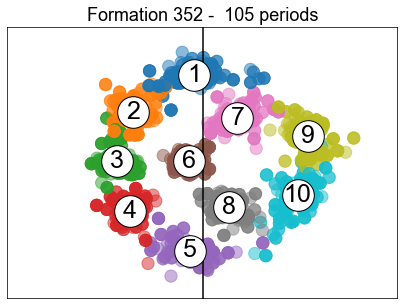

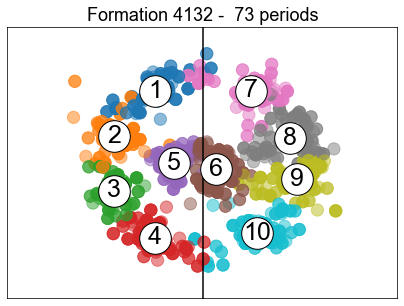

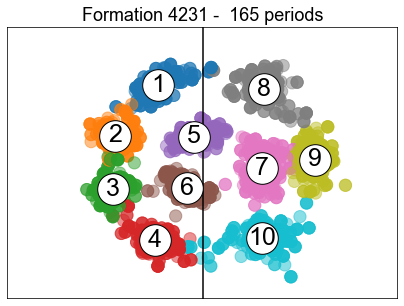

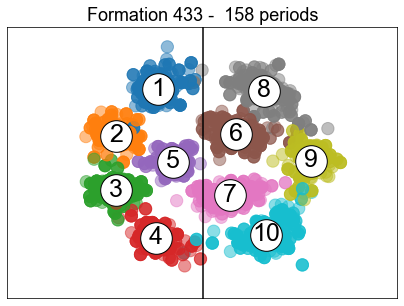

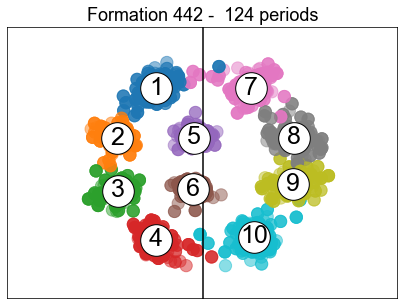

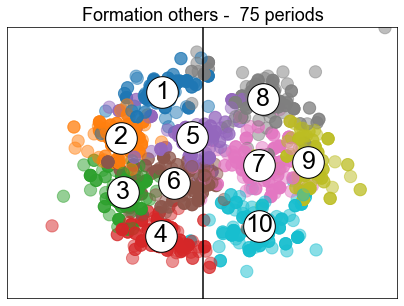

In [16]:
fm = FormManager(form_periods, role_records)
fm.align()
fm.visualize()

In [17]:
total_dur = form_periods[LABEL_DURATION].sum()
form_durs = form_periods.groupby(LABEL_FORMATION)[LABEL_DURATION].sum()

counts = form_periods[LABEL_FORMATION].value_counts()
form_props = (form_durs / total_dur).round(4)
form_mean_durs = (form_durs / form_periods[LABEL_FORMATION].value_counts()).round(1)

counts.name = 'count'
form_props.name = 'proportion'
form_mean_durs.name = 'mean_dur'

pd.concat([counts, form_props, form_mean_durs], axis=1)

,count,proportion,mean_dur
343,183,0.2122,2698.3
4231,165,0.1972,2781.1
433,158,0.1794,2641.5
442,124,0.1472,2762.7
352,105,0.1198,2654.3
others,75,0.0644,1997.9
4132,73,0.0797,2540.5


In [18]:
role_labels = pd.DataFrame([
    ['343', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'RCM', 'LCM', 'LM', 'CF', 'RM'],
    ['352', 'LWB', 'LCB', 'CB', 'RCB', 'RWB', 'CDM', 'LCM', 'RCM', 'LCF', 'RCF'],
    ['442', 'LB', 'LCB', 'RCB', 'RB', 'LCM', 'RCM', 'LM', 'LCF', 'RCF', 'RM'],
    ['4231', 'LB', 'LCB', 'RCB', 'RB', 'LDM', 'RDM', 'CAM', 'LM', 'CF', 'RM'],
    ['433', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'LCM', 'RCM', 'LM', 'CF', 'RM'],
    ['4132', 'LB', 'LCB', 'RCB', 'RB', 'CDM', 'CAM', 'LM', 'LCF', 'RCF', 'RM'],
    ['others'] + [f'R{i}' for i in list(range(1, 11))]
], columns=[LABEL_FORMATION] + list(range(1, 11))).set_index(LABEL_FORMATION)

def give_role_labels(role_records, role_labels):
    formation = role_records[LABEL_FORMATION].iloc[0]
    role_dict = role_labels.loc[formation].to_dict()
    role_records.loc[role_records.index, LABEL_ALIGNED_ROLE] = (
        role_records.loc[role_records.index, LABEL_ALIGNED_ROLE].replace(role_dict)
    )
    return role_records

def hungarian(unit_role_records):
    cost_mat = unit_role_records[ordinary_roles].values
    _, col_idx = linear_sum_assignment(cost_mat)
    role_records.loc[unit_role_records.index, LABEL_ALIGNED_ROLE] = ordinary_roles[col_idx]
    # return unit_role_records[HEADER_ROLE_RECORDS + [LABEL_ALIGNED_ROLE]]

In [19]:
role_records = fm.role_records.groupby(LABEL_FORMATION).apply(give_role_labels, role_labels)
ordinary_role_records = role_records[role_records[LABEL_FORMATION] != 'others']
ordinary_roles = ordinary_role_records[LABEL_ALIGNED_ROLE].unique()

role_distns = ordinary_role_records.groupby(LABEL_ALIGNED_ROLE).apply(
    RoleRep.estimate_mvn, col_x=LABEL_X, col_y=LABEL_Y, filter=False
)
other_form_periods = form_periods[form_periods[LABEL_FORMATION] == 'others']
other_role_records = pd.merge(role_records, other_form_periods[[LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD]])

cost_df = role_distns.apply(
    lambda n: pd.Series(-np.log(n.pdf(other_role_records[[LABEL_X, LABEL_Y]])))
).transpose()
other_role_records = pd.concat([other_role_records, cost_df], axis=1)
other_role_records.index = role_records[role_records[LABEL_FORMATION] == 'others'].index
other_role_records.groupby([LABEL_ACTIVITY_ID, LABEL_ROLE_PERIOD]).apply(hungarian)

role_records.to_csv(f'data/{mode}/role_records.csv', index=False)

### Model Evaluation

In [20]:
import seaborn as sns
sns.set(font='Arial', font_scale=1.5)

In [21]:
role_tags_true = pd.read_csv('data/role_tags_true.csv', header=0)
form_tags_true = role_tags_true[role_tags_true.columns[:-2]].drop_duplicates().reset_index(drop=True)

cols = [LABEL_ACTIVITY_ID, LABEL_FORM_PERIOD, LABEL_FORMATION]
form_tags_pred = pd.merge(role_periods, form_periods[cols])

activity_ids = form_tags_true[LABEL_ACTIVITY_ID].unique()
form_tags_pred = form_tags_pred[
    form_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)
].reset_index(drop=True)
form_tags_pred

,activity_id,player_period,form_period,role_period,session,start_time,end_time,formation
0,2310,1,1,1,1,0,7,4132
1,2310,1,1,2,1,7,16,4132
2,2310,1,1,3,1,16,35,4132
3,2310,1,1,4,1,35,46,4132
4,2310,2,2,5,2,0,22,442
...,...,...,...,...,...,...,...,...
156,21704,1,1,3,1,23,31,442
157,21704,1,1,4,1,31,47,442
158,21704,2,2,5,2,0,6,442
159,21704,2,2,6,2,6,11,442


In [22]:
form_header = [LABEL_ACTIVITY_ID, LABEL_SESSION, LABEL_START_TIME, LABEL_FORMATION]
role_header = form_header[:3] + [LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]

def generate_minute_segments_inner(records, i, mode='form'):
    row = records.iloc[i]

    start_time = row[LABEL_START_TIME]
    end_time = row[LABEL_END_TIME]
    duration = end_time - start_time
    
    cols = form_header if mode == 'form' else role_header
    minute_df = pd.DataFrame(np.repeat(row[cols].values[np.newaxis], duration, axis=0), columns=cols)
    minute_df[LABEL_START_TIME] = np.arange(start_time, end_time)
    
    return minute_df

def generate_minute_segments(records, mode='form'):
    minute_df_list = Parallel(n_jobs=50)(
        delayed(generate_minute_segments_inner)(records, i, mode=mode)
        for i in tqdm(records.index)
    )
    cols = form_header if mode == 'form' else role_header
    return pd.concat(minute_df_list).sort_values(cols)

100%|██████████| 161/161 [00:00<00:00, 9568.84it/s]


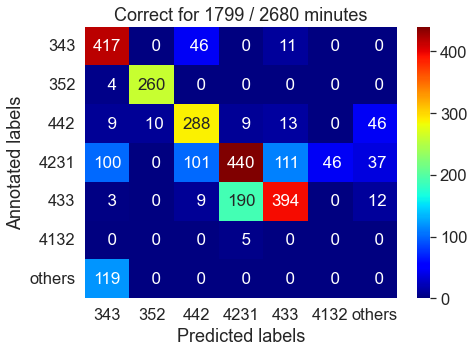

In [23]:
minute_df_true = generate_minute_segments(form_tags_true)
minute_df_pred = generate_minute_segments(form_tags_pred)

formations = ['343', '352', '442', '4231', '433', '4132', 'others']
minute_df_true[LABEL_FORMATION] = minute_df_true[LABEL_FORMATION].astype(str).apply(
    lambda x: x if x in formations[:-1] else 'others'
)

conf_mat = confusion_matrix(
    minute_df_true[LABEL_FORMATION].values,
    minute_df_pred[LABEL_FORMATION].values,
    labels=formations
)
conf_mat = pd.DataFrame(conf_mat, index=formations, columns=formations)
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(7, 5))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, cmap='jet', annot=True, fmt='3d', annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig(f'img/form_conf_{mode}.pdf', bbox_inches='tight')

100%|██████████| 1718/1718 [00:03<00:00, 490.00it/s]


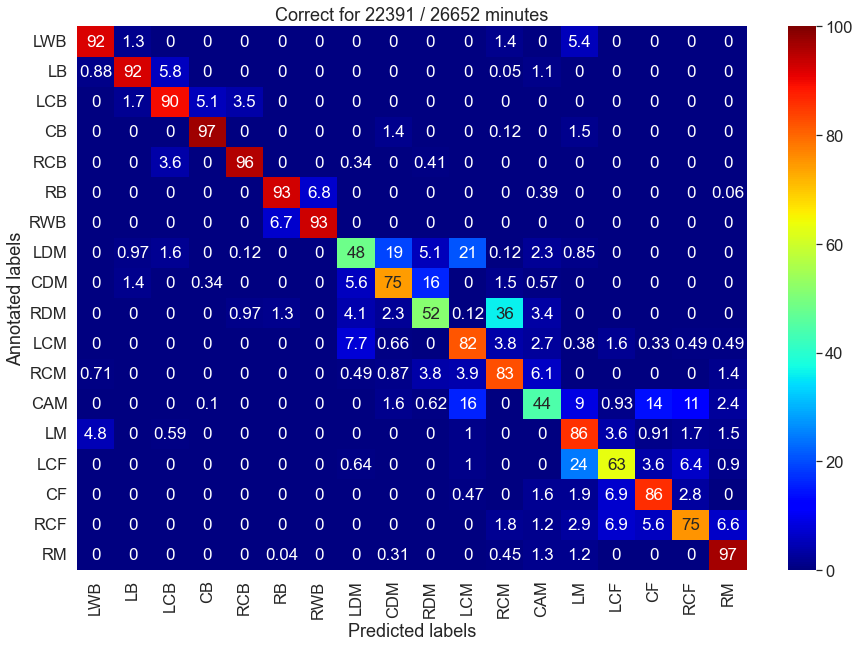

In [24]:
right_cols = (
    HEADER_ROLE_RECORDS[:5] +
    [LABEL_FORMATION, LABEL_PLAYER_ID, LABEL_SQUAD_NUM, LABEL_ALIGNED_ROLE]
)
role_tags_pred = pd.merge(role_periods, role_records[right_cols])

activity_ids = role_tags_true[LABEL_ACTIVITY_ID].unique()
records = role_tags_pred[role_tags_pred[LABEL_ACTIVITY_ID].isin(activity_ids)].reset_index(drop=True)
minute_df_pred = generate_minute_segments(records, mode='role')

minute_df_true = generate_minute_segments(role_tags_true, mode='role')
minute_df_true = pd.merge(minute_df_pred[role_header[:-1]], minute_df_true)

roles = [
    'LWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'RWB',
    'LDM', 'CDM', 'RDM', 'LCM', 'RCM', 'CAM',
    'LM', 'LCF', 'CF', 'RCF', 'RM'
]
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles
)
conf_mat = confusion_matrix(
    minute_df_true[LABEL_ALIGNED_ROLE].values,
    minute_df_pred[LABEL_ALIGNED_ROLE].values,
    labels=roles, normalize='true'
)
conf_mat = pd.DataFrame(conf_mat, index=roles, columns=roles).round(4) * 100
minute_df_common = pd.merge(minute_df_true, minute_df_pred)

plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
sns.heatmap(conf_mat, vmin=0, vmax=100, cmap='jet', annot=True, annot_kws={"size": 17,})
plt.title(f"Correct for {len(minute_df_common)} / {len(minute_df_true)} minutes")
plt.xlabel("Predicted labels")
plt.ylabel("Annotated labels")
plt.savefig(f'img/role_conf_{mode}.pdf', bbox_inches='tight')